# General analysis of tank data in World of Tanks

## What's this and how was it obtained?

This is an analysis of some data about tanks in World of Tanks. The data was obtained using the Wargaming.net Public API on March 2021, for patch 1.2, and was extracted by calling the metod [vehicles](https://developers.wargaming.net/reference/all/wot/encyclopedia/vehicles/) to obtain all vehicles with their list of modules, and then [vehicle profile](https://developers.wargaming.net/reference/all/wot/encyclopedia/vehicleprofile) to obtain data about each configuration. A subset of the information obtained was saved as a CSV file that you can find [here](wot_data.csv).

I wanted to have the information in CSV format to be able to play with it in a spreadsheet, but I quickly found that it was too much information: there are many tanks and many configurations. That's why in the end I decided to analyze it using Python (with Matplotlib, Pandas and Seaborn). Pull requests and tips for improving the code are appreciated: I know there has to be a better way... Probably, there are even errors!

What's the goal of all of this? Nothing in particular: just trying to visualize the data about the tanks and answer some questons that pique my curiosity.

# Tanks per tier and type

First question: how many tanks are there? Let's start by reading the CSV file, which has one line per tank configuration.

In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import HTML

sns.set(rc={
    'figure.figsize':(18,7),
    'axes.titlesize': 18
})

df = pd.read_csv("wot_data.csv", sep=";")

# Clean up so that tanks are ordered by nation, tier and type
types = ["heavy", "medium", "light", "destroyer", "arty"]
df = df.replace(
    ["heavyTank", "mediumTank", "lightTank", "AT-SPG", "SPG"],
    types
)
df.type = pd.Categorical(df["type"], types, ordered=True)

nations = ["Germany", "USSR", "USA", "France", "UK", "China", "Japan", "Czech", "Poland", "Sweden", "Italy" ]
df = df.replace(
    ["germany", "ussr", "usa", "france", "uk", "china", "japan", "czech", "poland", "sweden", "italy"],
    nations
)
df.nation = pd.Categorical(df["nation"], nations, ordered=True)

df.sort_values(["nation", "tier", "type"], ascending=True)

num_confs = len(df)
num_tanks = len(df.name.unique())
avg_confs_per_tank = num_confs/num_tanks
print(f'Number of configurations: {num_confs}.\nNumber of tanks: {num_tanks}.\nAverage number of configurations per tank: {avg_confs_per_tank}')

Number of configurations: 14522.
Number of tanks: 685.
Average number of configurations per tank: 21.2


Wow! There are 685 tanks and the average number of configurations per tank is 21.2. That's a lot of variety, but you have to take into account that when you have three radios, for instance, you are multpliying your configurations by 3 without changing the play style of the tank.

However, an interesting question is: are the configurations distributed uniformly or are there tanks with many more configurations than others. Let's plot an histogram.

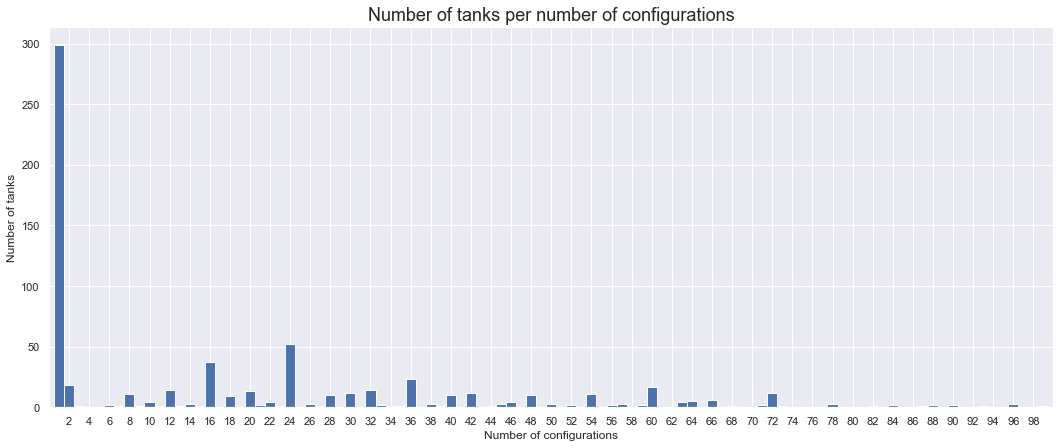

In [154]:
conf_count = df.groupby("name")["name"].count()
bins = np.arange(conf_count.min(), conf_count.max()+2, 1)-0.5

ax = conf_count.hist(bins=bins)
ax.set_xlim(0, 100)
ax.set_xlabel("Number of configurations")
ax.set_ylabel("Number of tanks")
plt.title("Number of tanks per number of configurations")
_= plt.xticks(range(2, 100, 2))

So almost 300 tanks only have one configuraton: they are probably premium and tier 10 tanks. We will check that later.

The next most probable value is 24 configurations, and there are even around 25 tanks with 36 configurations. But the previous histogram was cut in order to be able to distinguish the bins. Which are the tanks with more configurations? Let's see:

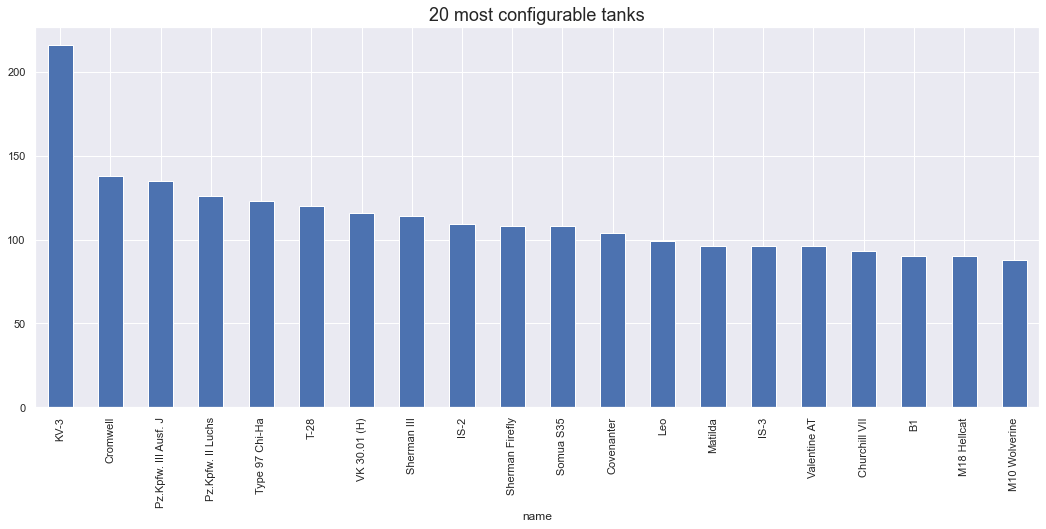

In [155]:
_ = conf_count.sort_values(ascending=False).head(20).plot(kind="bar", title="20 most configurable tanks")

The KV-3 is really configurable... 213 possibilities! Why is that? How many modules does it have?

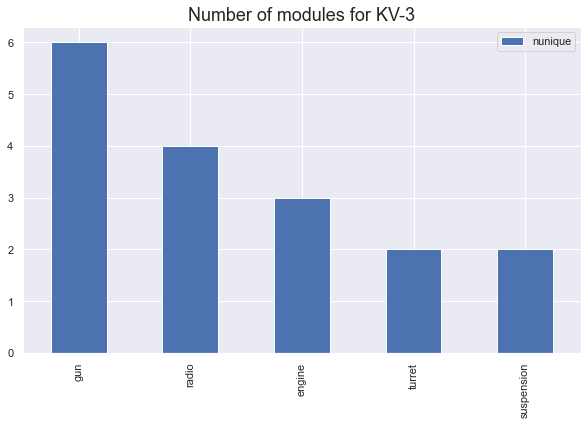

In [210]:
_ = (df[df.name=="KV-3"][["gun", "engine", "radio", "turret", "suspension"]]
        .agg(['nunique']).T.sort_values(by="nunique", ascending=False)
        .plot(kind="bar", title="Number of modules for KV-3", figsize=(10,6)))

Six guns and four radios. Not bad, not bad...

Previously I guessed that there were so many tanks with only one configuration because they were tier 10 or premiums. Let's check the distribution of number of configurations per tier:

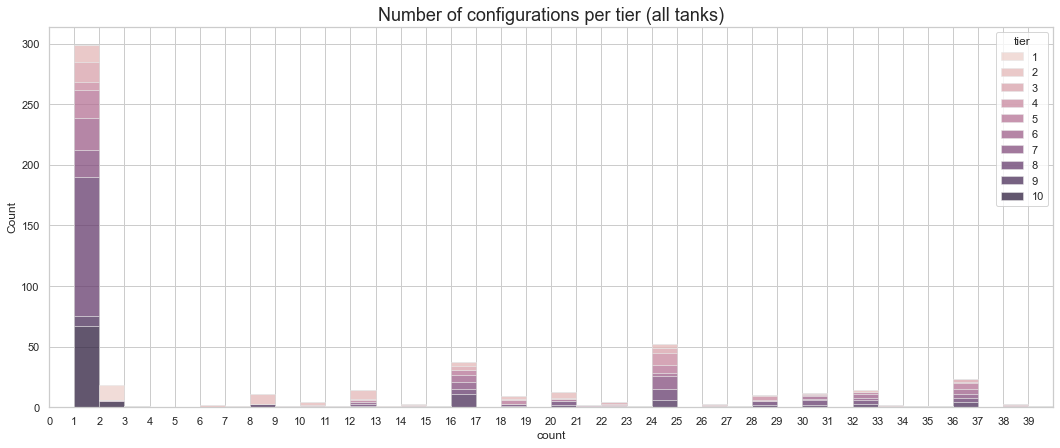

In [157]:
conf_tier_count = df.groupby(["name", "tier"]).count().reset_index()[["name", "tier", "is_premium", "short_name"]].rename(columns={"short_name": "count"})
with sns.axes_style("whitegrid"):
    ax = sns.histplot(data=conf_tier_count, x="count", hue="tier", multiple="stack", binwidth=1, edgecolor=".9", linewidth=.5,)
    _ = ax.set_xlim(0, 40)
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title("Number of configurations per tier (all tanks)")
    _ = ax.set_xticks(range(40))

We can see that there are around 75 tier 10 tanks with only one cofiguration, but there are even more tier 8 tanks with one configuration. In addition, we can see around 20 tanks with only two configurations and they are either tier 1 or tier 10.

Let's plot only non-premium tanks:

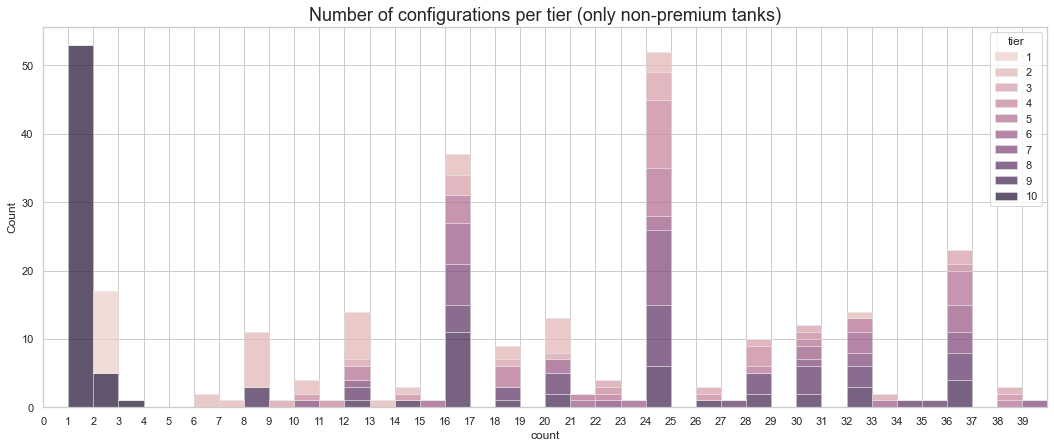

In [158]:
conf_tier_count = df[df.is_premium != True].groupby(["name", "tier"]).count().reset_index()[["name", "tier", "short_name"]].rename(columns={"short_name": "count"})
with sns.axes_style("whitegrid"):
    ax = sns.histplot(data=conf_tier_count, x="count", hue="tier", multiple="stack", binwidth=1, edgecolor=".9", linewidth=.5,)
    _ = ax.set_xlim(0, 40)
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title("Number of configurations per tier (only non-premium tanks)")
    _ = ax.set_xticks(range(40))

We can see that all non-premium tanks with only one configuration are tier 10. But there are almost 300 tanks with only one configuration and now we only have a little more than 50... So, how many premium tanks are there?

There are 438 premium tanks and 247 non-premium tanks.


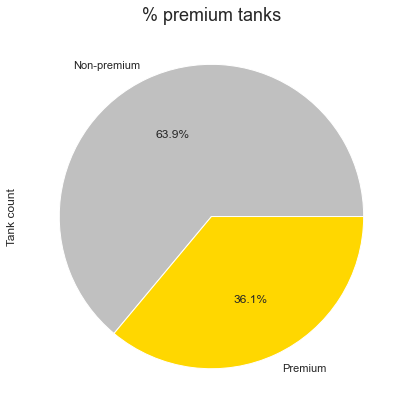

In [214]:
gr = df[["name", "type", "dpm", "tier", "nation", "is_gift", "speed_forward", "speed_backward", "is_premium"]].groupby(["name"]).agg(
    { 'type': 'first',
      'dpm': 'max',
      'tier': 'first',
      'nation': 'first',
      'is_gift': 'first',
      'speed_forward': 'max',
      'speed_backward': 'max',
      'is_premium': 'first',
      }).reset_index()
gr.type = pd.Categorical(gr["type"], types, ordered=True)
gr.nation = pd.Categorical(gr["nation"], nations, ordered=True)

premium = gr.groupby(["tier", "is_premium"]).count()["type"].reset_index().rename(columns={'type':'Tank count'})
premium.is_premium.replace(True, "Premium", inplace=True)
premium.is_premium.replace(False, "Non-premium", inplace=True)
premium_count = premium.groupby("is_premium").sum()["Tank count"]
_ = premium_count.plot(kind="pie", title="% premium tanks", autopct='%1.1f%%', colors = ['silver', 'gold'], legend=False)
print(f'There are {premium_count["Non-premium"]} premium tanks and {premium_count["Premium"]} non-premium tanks.')

Let's plot them by tier:

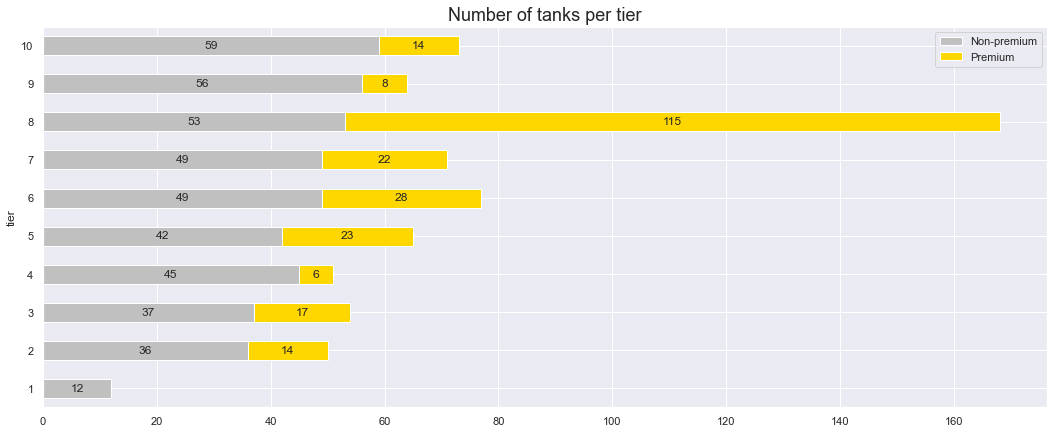

In [215]:
premimum_by_tier = premium.groupby(["tier", "is_premium"]).sum().unstack().fillna(0).droplevel(0, axis=1)
ax = premimum_by_tier.plot.barh(stacked=True, color=['silver', 'gold'], title="Number of tanks per tier")
for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{int(width)}'
    
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)
_ = ax.legend(['Non-premium', 'Premium'])

Things we can see:

- There are between 36 and 59 non-premium tanks per tier between tiers 2 and 10.

- There is much more variation in the number of premimum tanks per tier: the minimum (discarding tier 1) is at layer 4, with only 6 premium tanks, while the maximum is at layer 8, with 115 tanks.

- Almost half of premium tanks are in tier 8. This can be seen better in this pie chart:

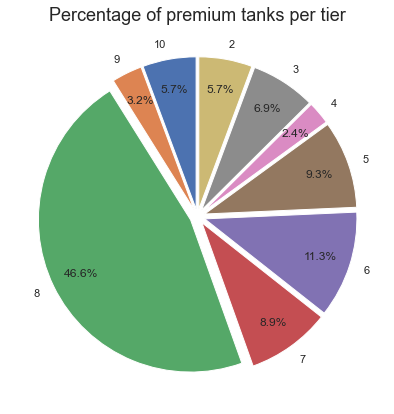

In [219]:
_ = premimum_by_tier["Premium"].iloc[::-1].iloc[:-1].plot(kind="pie",
        autopct='%1.1f%%', pctdistance=0.8, startangle=90, explode=[0.05]*9, legend=False,
        title="Percentage of premium tanks per tier").set_ylabel("")

What about the distribution of tanks per nation and type?

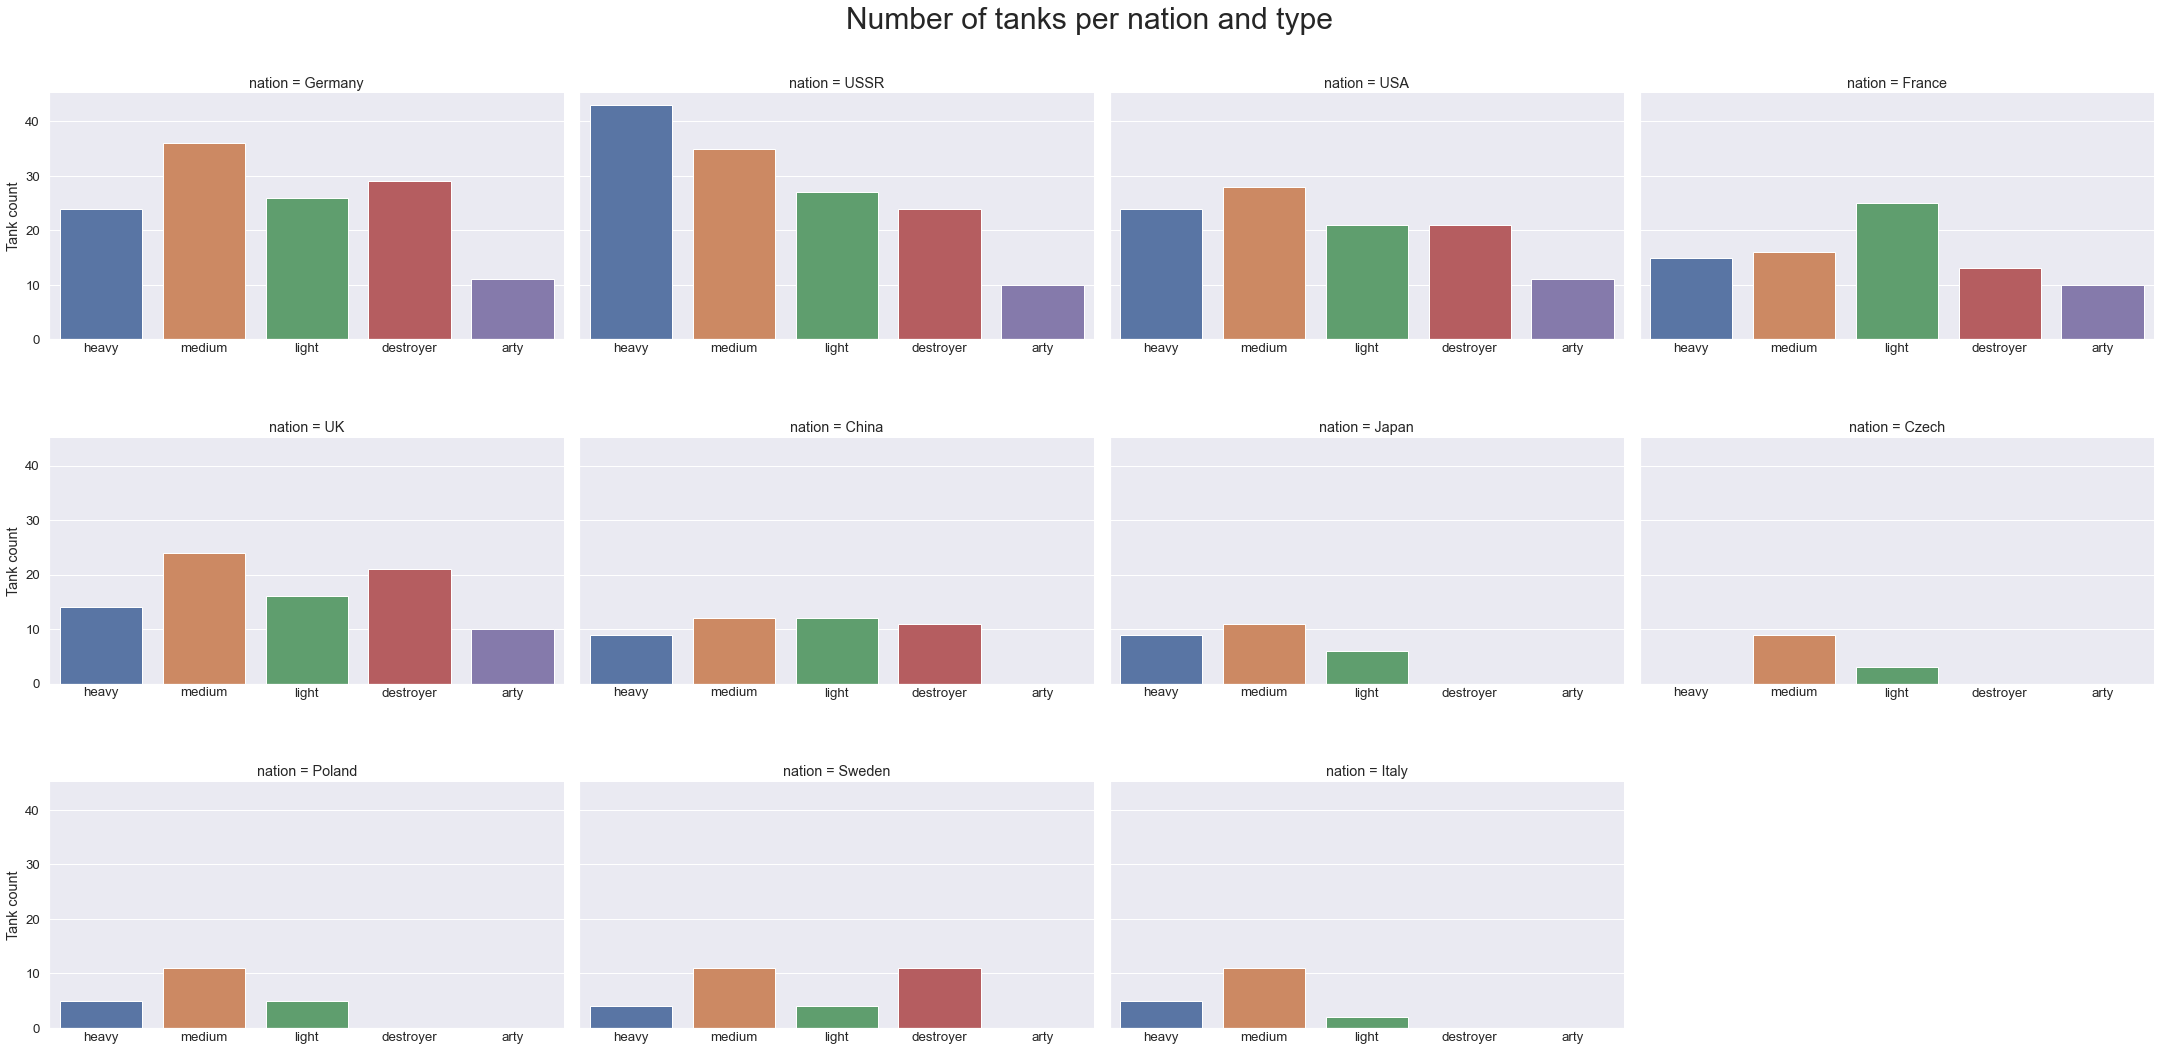

In [162]:
gr_nat_type = gr.groupby(["nation", "type"]).count().rename(columns={'dpm': 'Tank count'})["Tank count"].reset_index()
with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.catplot(data=gr_nat_type, x="type", y="Tank count", col="nation", kind="bar", col_wrap=4, col_order=nations, aspect=1.5)
    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True, axis="x", direction="in")
        ax.set_xlabel('')
    plt.subplots_adjust(hspace=0.4)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Number of tanks per nation and type", size=30)
    

There are some apparent patterns:

- Germany and UK: focused on mediums and tank destroyers.
- USSR: focused on heavy tanks, although it is the nation with more tanks and the number of mediums (second type for USSR) is similar to number of mediums in Germany (first type for Germany).
- USA: quite balanced, with a little more mediums.
- Tank destroyers and arties are usually not present in the nations most-recently added, except for Sweden, that has a tank destroyer line.

And what about the number of tanks independtly of nation?

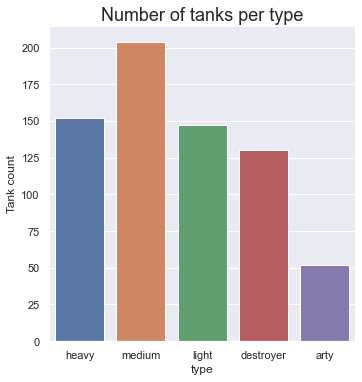

In [163]:
gr_type = gr.groupby(["type"]).count().rename(columns={'dpm': 'Tank count'})["Tank count"].reset_index()
g = sns.catplot(data=gr_type, x="type", y="Tank count", kind="bar")
_ = plt.title("Number of tanks per type")

There are more than 200 mediums and around 150 heavies and lights. Tank destroyers lag behind at 125 while there are only around 50 arties.

Let's see how many tanks each nation has...

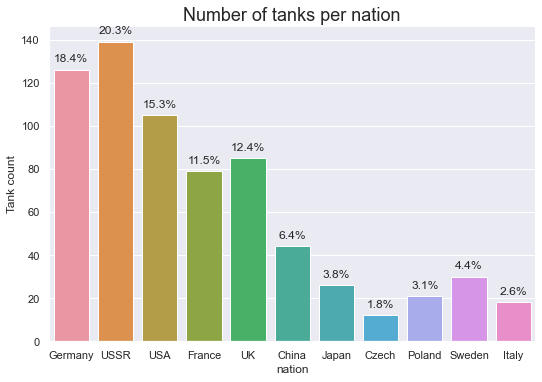

In [204]:
gr_type = gr.groupby(["nation"]).count().rename(columns={'dpm': 'Tank count'})["Tank count"].reset_index()
g = sns.catplot(data=gr_type, x="nation", y="Tank count", kind="bar", aspect=1.5)
total_tank_count = gr_type["Tank count"].sum()
for i, bar in enumerate(g.ax.patches):
    h = bar.get_height()
    perct = bar.get_height()*100/total_tank_count
    g.ax.text(i, h+5, f'{perct:.1f}%', ha='center', va='center')
_ = plt.title("Number of tanks per nation", size=18)


Although I was under the impression that the five big nations had a similar number of tanks, but USSR has almost twice the number of tanks of France.